#Recap

## Scaled Dot Product Attention


**Вернемся в предыдущий ноутбук**

---

# Test Time Scaling


## Chain Of Thoughts


**Chain of Thought (цепочка размышлений)** — это техника, при которой модель генерирует промежуточные шаги рассуждения перед тем, как дать финальный ответ. Она особенно полезна в задачах, требующих логического мышления или арифметических вычислений.

### Пример:
**Вопрос:** Если у Маши 3 яблока, а у Пети в 2 раза больше, сколько всего яблок?

**Без CoT:** 6

**С CoT:** У Маши 3 яблока. У Пети в 2 раза больше: 3 * 2 = 6. Всего: 3 + 6 = 9.

Эта техника помогает:
- Увеличить точность в сложных задачах
- Сделать поведение модели более интерпретируемым



## Thinking with Reinforcement Learning

### Почему RL?
Вместо обучения модели только на готовых примерах, можно позволить ей исследовать разные стратегии рассуждения и поощрять те, что приводят к правильным ответам. Это позволяет находить нестандартные, но эффективные пути решения задач.

### PPO vs GRPO

**PPO (Proximal Policy Optimization):**
- Нужна человеческая разметка вариантов ответов - отсюда и пошло **RLHF** (Reinforcement Learning from Human Feedback)
- Сложно завести, сделать так, чтобы это работало

**GRPO (Generalized Reward Policy Optimization):**
- Упрощает идею PPO
- Вместо обучаемой *Value* (*Critic*) модели используются валидируемые правила - Rule-Based подход
- Умеет оцениваеть *Reward* для промежуточных шагов

### PPO vs GRPO
| Характеристика | PPO | GRPO |
|----------------|-----|------|
| Нужна ли человеческая разметка | Да | Нет |
| Учет промежуточных шагов | Ограниченно | Да |
| Reward модель | Обучаемая отдельная LLM | Rule-based |

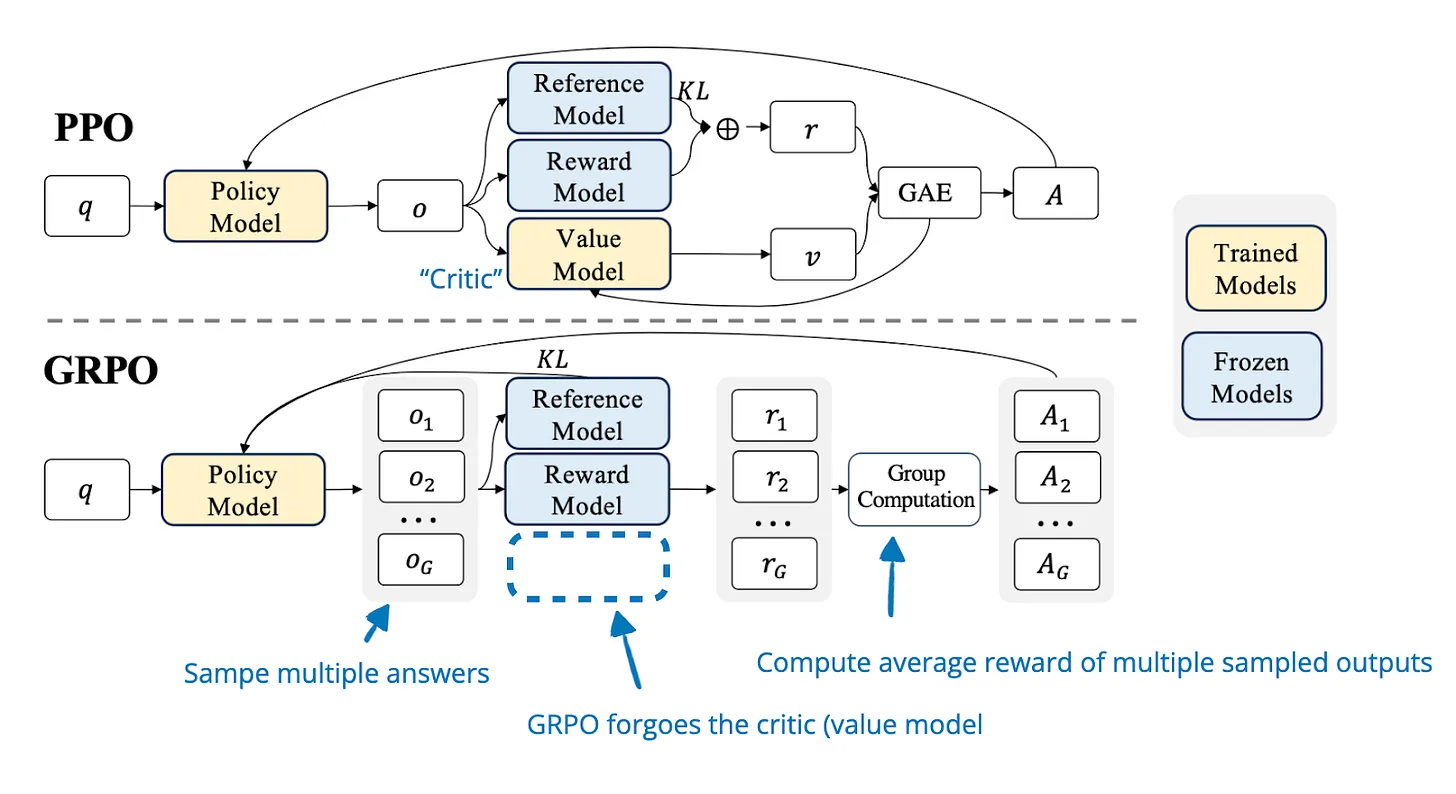

[Источник картинки](https://magazine.sebastianraschka.com/p/the-state-of-llm-reasoning-model-training)

[Первоисточник картинки DeepSeek Math](https://arxiv.org/pdf/2402.03300)

## На сколько это эффективно?

[Learning to reason with LLMs](https://openai.com/index/learning-to-reason-with-llms/)

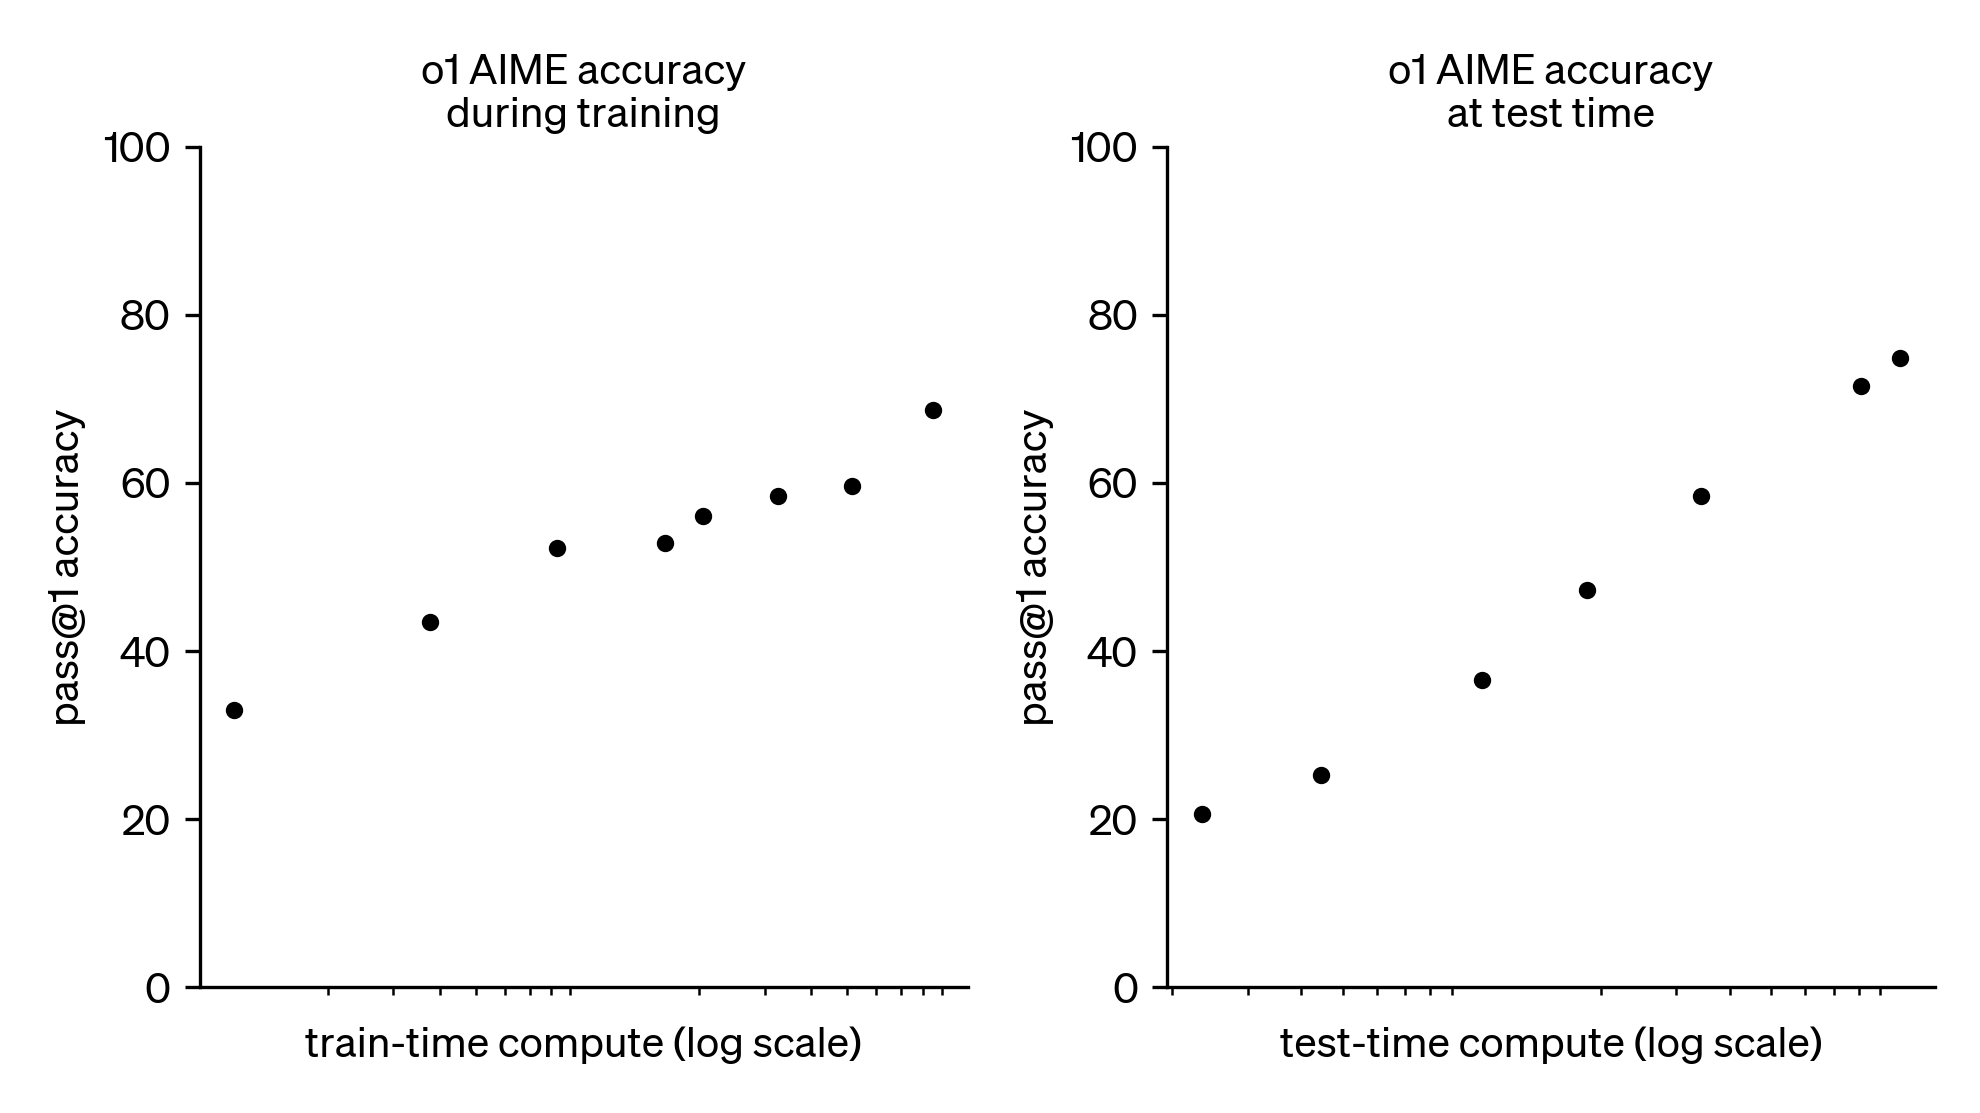

### LiveBench

[LiveBench](https://livebench.ai/#/): a benchmark for LLMs designed with test set contamination and objective evaluation in mind. It has the following properties:

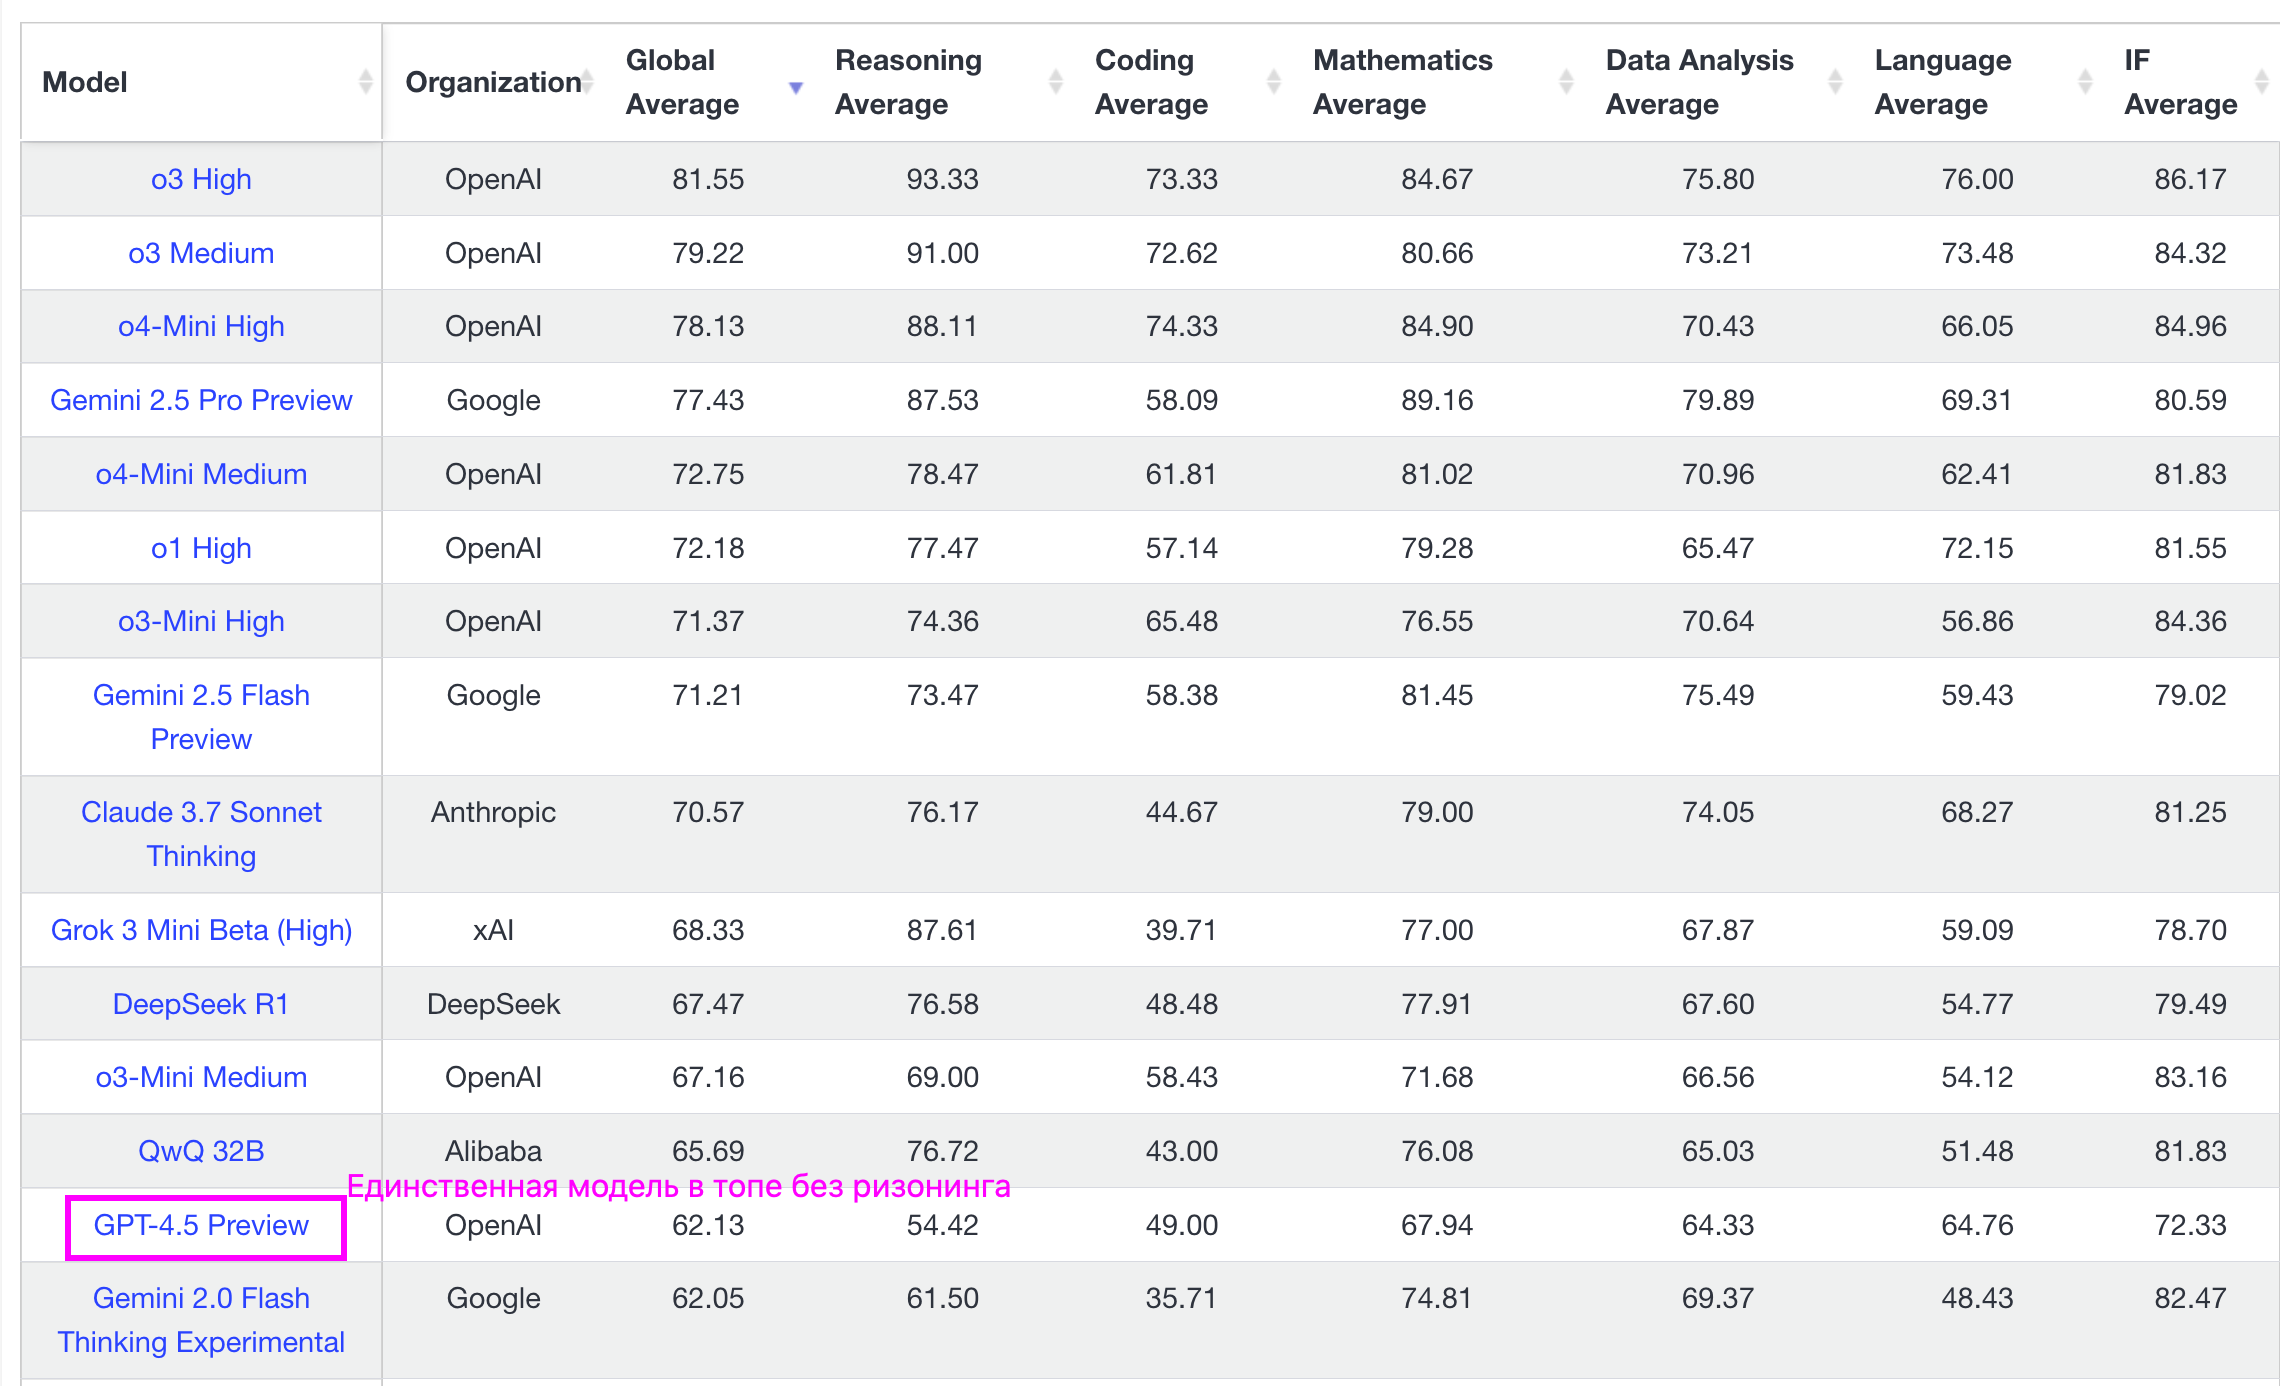

## [Thinking Tokens - Quiet Star](https://www.alphaxiv.org/abs/2403.09629) (2024)

[**GitHub Repo**](https://github.com/ezelikman/quiet-star)

**Ключевые моменты:**
* Бэкбон Mistral 7B
* Размышления не только в начале генерации, а в произвольном месте
* Размышления никак не валидируются
* Не нужно собирать специальные датасеты для обучения


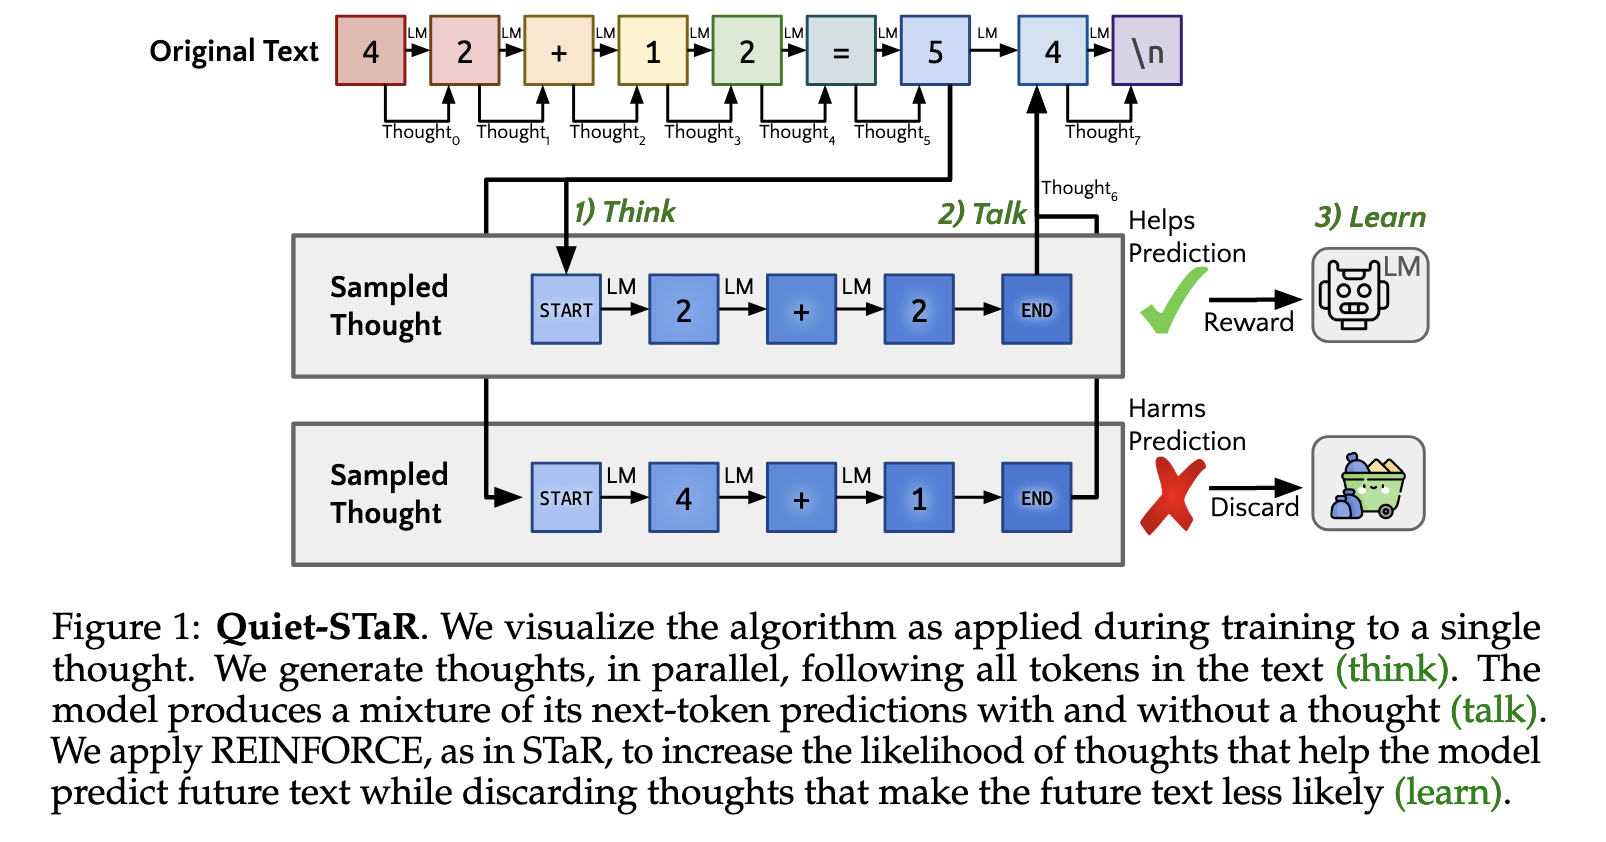

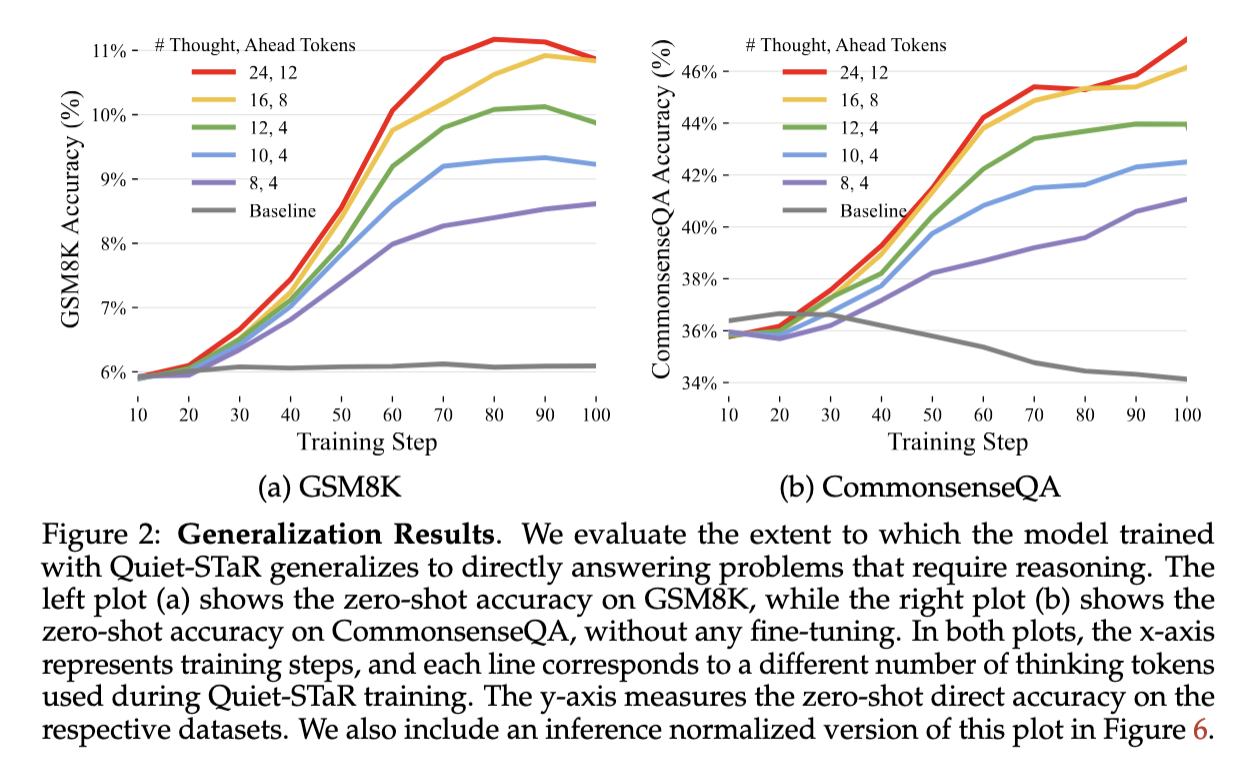

## [Coconut: Training Large Language Models to Reason in a Continuous Latent Space](https://www.alphaxiv.org/abs/2412.06769)

* Pretrain on CoT
* Replace CoT in training data with `N` "Continuous Thought Tokens"
* Requires `N+1` forward passes


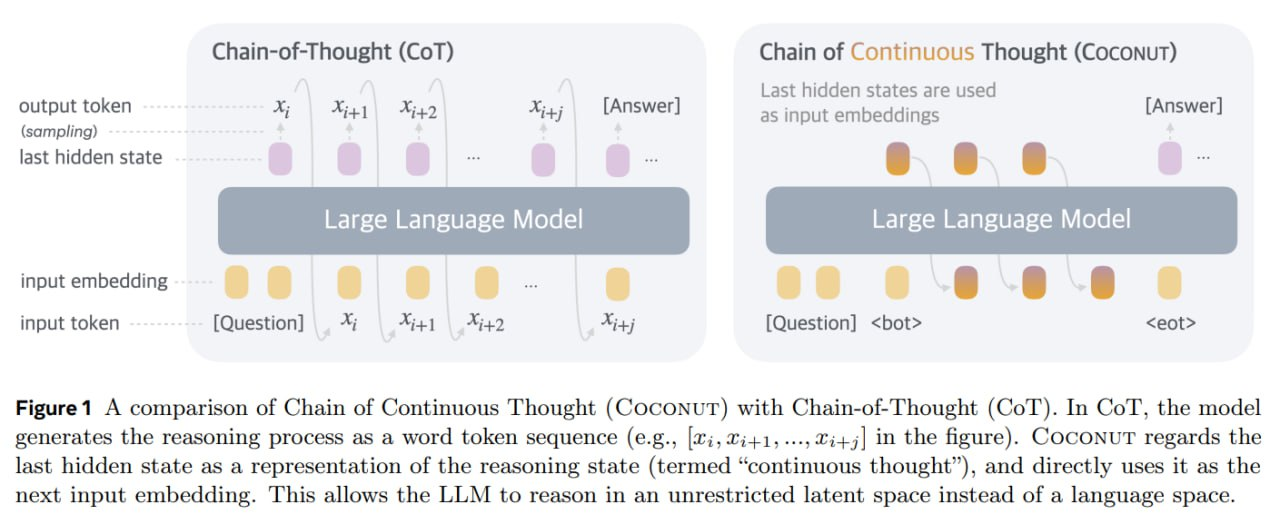



## GRPO Samping

[🤗 huggingface/trl GRPO Trainer](https://github.com/huggingface/trl/blob/main/trl/trainer/grpo_trainer.py)

In [1]:
!pip install transformers

In [29]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = 'Qwen/Qwen2-0.5B-Instruct'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [91]:
num_generations = 64


MATH500_problem = """
Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\\theta),$ where $r > 0$ and $0 \le \\theta < 2 \pi.$
"""

model_inputs = tokenizer( [ MATH500_problem ], return_tensors='pt' )
model_inputs = model_inputs.to(device)

input_ids = model_inputs['input_ids']
attention_mask = model_inputs['attention_mask']

input_ids.shape

torch.Size([1, 49])

In [92]:
input_ids = input_ids.repeat([num_generations, 1])
attention_mask = attention_mask.repeat([num_generations, 1])

input_ids.shape

torch.Size([64, 49])

In [93]:
model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.1,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

In [44]:
generation_config = {
    "do_sample": False,
    "temperature": 0.9,
    "top_p": 1.0,
    "top_k": None,
    "min_p": None,
    "repetition_penalty": 1.0,
}

output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    **generation_config
)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [45]:
decoded_generations = tokenizer.batch_decode(output)
print("Total generations", len(decoded_generations))
print("Total unique generations", len(set(decoded_generations)))

Total generations 64
Total unique generations 1


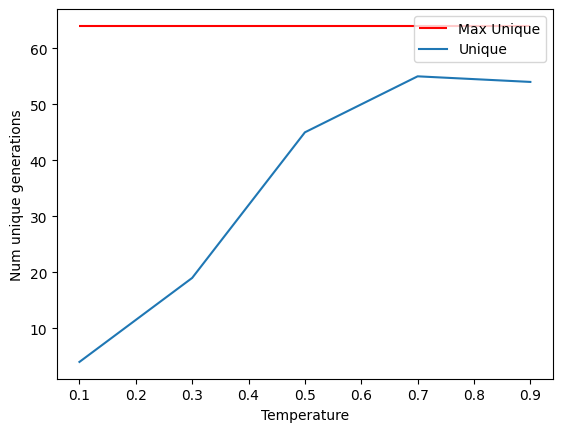

In [58]:
import matplotlib.pyplot as plt
import numpy as np

generation_config['do_sample'] = True

temperatures_range = np.arange(1, 10, 2) / 10
uniq_generations = []

for temperature in temperatures_range:
    generation_config['temperature'] = temperature
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        **generation_config
    )
    decoded_generations = tokenizer.batch_decode(output)

    uniq_generations.append(len(set(decoded_generations)))

plt.ylabel("Num unique generations")
plt.xlabel("Temperature")
plt.hlines([ input_ids.shape[0] ], 0.1, 0.9, color='red', label='Max Unique')
plt.plot(temperatures_range, uniq_generations, label='Unique')
plt.legend()

#### Temperature visualization

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlabel('Token Index', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Effect of Temperature (0-10) on Sampling Distribution', fontsize=14, pad=20)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# Original logits (model outputs before softmax)
logits = np.array([2.0, 1.5, 1.0, 0.5, 0.1])  # More varied distribution
token_labels = ['Token 1', 'Token 2', 'Token 3', 'Token 4', 'Token 5']

# Initialize bars with colors
colors = plt.cm.viridis(np.linspace(0, 1, len(logits)))
bars = ax.bar(token_labels, [0]*len(logits), color=colors)
texts = [ax.text(bar.get_x() + bar.get_width()/2, 0, '',
                ha='center', va='bottom', fontsize=10) for bar in bars]

# Temperature annotation with enhanced visibility
temp_text = ax.text(0.02, 0.95, 'Temperature: 0.00', transform=ax.transAxes,
                   ha='left', va='top', fontsize=14,
                   bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

# Add colorbar to show temperature scale
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=10))
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Temperature Scale', rotation=270, labelpad=15)

def apply_temperature(logits, temperature):
    """Apply temperature scaling to logits"""
    if temperature == 0:  # Handle zero temperature case
        temperature = 1e-10  # Very small value to avoid division by zero
    scaled_logits = logits / temperature
    return softmax(scaled_logits)

def update(frame):
    # Linear temperature range from 0 to 10
    temp = frame * 10 / 500  # frame goes from 0 to 100

    # Apply temperature
    probs = apply_temperature(logits, temp)

    # Update bars
    for bar, prob in zip(bars, probs):
        bar.set_height(prob)
        # Change color intensity based on temperature
        r, g, b, a = bar.get_facecolor()
        intensity = 0.5 + 0.5 * (temp / 10)  # Vary intensity with temperature
        bar.set_facecolor((r, g, b, intensity))

    # Update probability labels
    for text, bar in zip(texts, bars):
        text.set_text(f'{bar.get_height():.2f}')
        text.set_y(bar.get_height() + 0.02)
        text.set_color('black' if bar.get_height() < 0.7 else 'white')

    # Update temperature display
    temp_text.set_text(f'Temperature: {temp:.2f}')
    temp_text.set_color('red' if temp > 1 else 'blue')

    # Return all artists that need to be redrawn
    return list(bars) + texts + [temp_text]

# Create animation (100 frames for smooth transition)
ani = FuncAnimation(fig, update, frames=np.linspace(0, 100, 100),
                   blit=True, interval=200, repeat_delay=2000)

# For Jupyter notebook display
plt.close()
HTML(ani.to_html5_video())

# To save the animation (uncomment if needed)
# ani.save('temperature_effect_0_to_10.mp4', writer='ffmpeg',

### Count correct threads

In [94]:
generation_config = {
    "do_sample": True,
    "temperature": 0.9,
    "top_p": 1.0,
    "top_k": None,
    "min_p": None,
    "repetition_penalty": 1.0,
    "max_new_tokens": 500,
}

output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    **generation_config
)

decoded_generations = tokenizer.batch_decode(output)

In [102]:
correct_answer = '3, \\frac{\pi}{2}'

print("Count correct answers", sum( correct_answer in x for x in decoded_generations ))

Count correct answers 4


In [104]:
partially_correct = '\\frac{\pi}{2}'

print("Count partially correct answers", sum( partially_correct in x for x in decoded_generations ))

Count partially correct answers 15


In [100]:
print(decoded_generations[1])


Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$
To convert the point $(0, 3)$ from rectangular coordinates to polar coordinates, we use the formula:

\[ r = \sqrt{x^2 + y^2} \]
\[ \theta = \arctan \left( \frac{y}{x} \right) \]

Plugging in the values, we get:

\[ r = \sqrt{0^2 + 3^2} = \sqrt{9} = 3 \]
\[ \theta = \arctan \left( \frac{3}{0} \right) \]
\[ \theta = -\frac{\pi}{2} \]

However, given that $r > 0$ and $0 \le \theta < 2\pi$, the value of $\theta$ becomes undefined because the negative result is not in the specified interval. Therefore, we consider the additional restriction that $\theta$ is between 0 and $\pi$. In this case, $\theta = -\frac{\pi}{2}$ is valid since it was introduced to ensure the result is in the correct interval, with $\theta = \pi$ not being valid because it exceeds the range $0 \le \theta < 2\pi$.

Thus, the point $(0, 3)$ in polar coordinates

## На каких задачах хороши ризонеры?

* Для сложных задач, в которых скорость не критична, но точность ответа важна

----

# Agents

## Что такое агентная система? Чем отличается от обычной LLM?

**Агентная система** — это система на основе ИИ, которая может принимать решения, взаимодействовать с окружающей средой, выполнять действия и адаптироваться к новым условиям. Она действует целенаправленно, обычно в рамках заданной задачи, используя свою память, инструменты и стратегию.

В отличие от **обычной LLM (Large Language Model)**, которая в основном отвечает на запросы пользователя на основе обученного распределения вероятностей слов, агент:
- Обладает **состоянием и памятью** (может помнить предыдущие действия или данные).
- Может **принимать решения** и **действовать итеративно**, строя план.
- Часто **использует внешние инструменты** (веб-браузер, калькулятор, API и т.д.).
- Работает в **цикле "восприятие → размышление → действие"**, а не только "ввод → вывод".


## Системы с одним агентом

Системы с одним агентом фокусируются на решении задач в одиночку. Пример:
- **LLM-агент, выполняющий задачу по поиску информации**, используя ReAct или Toolformer.
- Применения: ассистенты, чат-боты, автоматизация задач (например, копирайтинг, парсинг данных).

Характеристики:
- Простой контроль за логикой.
- Четкая последовательность шагов.
- Можно эффективно использовать цепочки мыслей (*chain of thought*) и планирование.


## Мультиагентные системы

**Мультиагентные системы (MAS)** — это архитектуры, в которых множество агентов взаимодействуют друг с другом для решения общей задачи.

Примеры:
- Агенты, играющие роли: исследователь, критик, программист.
- Команда агентов, выполняющая задачу коллективно: один собирает данные, другой их анализирует, третий генерирует отчет.

Характеристики:
- **Разделение ролей и специализация.**
- **Коммуникация и координация.**
- Потенциал для **масштабируемости и эффективности**, но выше сложность управления.


## Инструменты для агентов

Агентные системы могут использовать внешние инструменты, расширяя свои возможности:

- **Браузеры и API-интерфейсы** (например, Wolfram Alpha, поисковые движки).
- **Калькуляторы и парсеры кода.**
- **Базы данных и память (vector DB, Redis, etc.).**
- Фреймворки:
  - 🧠 **LangChain** — инфраструктура для создания агентных систем с памятью, инструментами и цепочками.
  - 🧠 **AutoGen** — библиотека от Microsoft для мультиагентных взаимодействий.
  - ⚙️ **OpenAI Function Calling** — механизм вызова внешних функций изнутри модели.
  - ⚙️ **LlamaIndex** — интеграция моделей с данными через индексы и агентов.


## Function Calling


#### Явное обучение: Toolformer / Toolken / Toolken++

| Характеристика                | **Toolformer**                                                                 | **Toolken**                                                                         | **Toolken++**                                                                         |
|------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| **Интеграция инструментов**  | Автономная генерация запросов во время преподготовки                           | Токены вызывают внешний API в момент генерации                                       | + Добавлены **slot-aware** вызовы и фильтрация по типу инструмента                      |
| **Главные преимущества**     | Не требует ручной аннотации, масштабируется                                    | Не нужно дообучать всю тушку трансформера. Только дополнительные эмбэддинги.                                               | Rejection тулза, Tools,reranking                 |
| **Ограничения**              | Работает только с тулзами, которые были в обучающем датасете. | Работает только с тулзами, которые были в обучающем датасете. | Работает только с тулзами, которые были в обучающем датасете. |




#### Как сейчас агенты узнают, какие есть инструменты и как их использовать? Как научить агентов пользоваться тулзами, которых не было в обучающей выборке?

- Инфо о тулзах просто передается в контекст модели - модель при обучении училась использовать инструменты



In [3]:
!pip install -q smolagents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.0 MB/s eta 0:00:00


In [1]:
from smolagents import Tool

from sympy import atan2, sqrt, simplify

class RectangularToPolarCoordinates(Tool):
    name = 'rectangular_to_polar_coordinates'
    description = 'This is a tool that transforms rectangular to polar coordinates'
    inputs = {
        'x': {
            "type": 'number',
            "description": 'x coordinate value in rectangular coordinates',
        },
        'y': {
            "type": 'number',
            "description": 'y coordinate value in rectangular coordinates',
        }
    }
    output_type = "string"

    def forward(self, x: float, y: float) -> str:
        r = sqrt(x**2 + y**2)
        theta = atan2(y, x)

        r = simplify(r)
        theta = simplify(theta)

        return f"({r:.2f}, {theta})"


rtpc_tool = RectangularToPolarCoordinates()
rtpc_tool.forward(0., 3.)

'(3.00, pi/2)'

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from smolagents import ToolCallingAgent, TransformersModel

model = TransformersModel(
    model_id="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    max_new_tokens=1024,
)

agent = ToolCallingAgent(
    tools=[ RectangularToPolarCoordinates() ],
    model=model,
    max_steps=5,
    verbosity_level=3,
)

math_500_agent_task_explisit_use_existing = "Convert the point $(0,3)$ in rectangular coordinates to polar coordinates. Use existing tools."

result = agent.run( math_500_agent_task_explisit_use_existing )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Convert the point $(0,3)$ in rectangular coordinates to polar coordinates. Use existing tools.                  │
│                                                                                                                 │
╰─ TransformersModel - HuggingFaceTB/SmolLM2-1.7B-Instruct ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Action:                                                                                                            
{                                                                                                                  
  "name": "rectangular_to_polar_coordinates",                                                                      
  "arguments": {"x": 0, "y": 3}                                                                                    
}                                                                                                                  
                                                                                                                   

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'rectangular_to_polar_coordinates' with arguments: {'x': 0, 'y': 3}                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: (3.00, pi/2)

[Step 1: Duration 3.74 seconds| Input tokens: 1,022 | Output tokens: 40]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Action:                                                                                                            
{                                                                                                                  
  "name": "final_answer",                                                                                          
  "arguments": "(3.00, \u03c0/2)"                                                                                  
}                                                                                                                  

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: (3.00, π/2)                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: (3.00, π/2)

[Step 2: Duration 2.44 seconds| Input tokens: 2,182 | Output tokens: 75]

In [ ]:
# Prompt sensitive

math_500_agent_task = "Convert the point $(0,3)$ in rectangular coordinates to polar coordinates."

result = agent.run( math_500_agent_task )

#### Code Agent

[ReAct (2023)](https://www.alphaxiv.org/abs/2210.03629)

In [4]:
from smolagents import CodeAgent

agent = CodeAgent(
    tools=[ RectangularToPolarCoordinates() ],
    model=model,
    max_steps=5,
    verbosity_level=3,
)

result = agent.run( math_500_agent_task_explisit_use_existing )

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Convert the point $(0,3)$ in rectangular coordinates to polar coordinates. Use existing tools.                  │
│                                                                                                                 │
╰─ TransformersModel - HuggingFaceTB/SmolLM2-1.7B-Instruct ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
assistant                                                                                                          
Thought: I need to convert the point $(0,3)$ from rectangular coordinates to polar coordinates.                    
Code:                                                                                                              
```python                                                                                                          
from math import sqrt                                                                                              
                                                                                                                   
rectangular_point = (0, 3)                                                                                         
polar_point = (sqrt(rectangular_point[0]**2 + rectangular_point[1]**2), atan2(rectangular_point[1],                
rectangular_point[0]))                                                                                             
final_answer(polar_point)                                                                                          
```                                                                                                                
                                                                                                                   
<end_code>                                                                                                         

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  from math import sqrt                                                                                            
                                                                                                                   
  rectangular_point = (0, 3)                                                                                       
  polar_point = (sqrt(rectangular_point[0]**2 + rectangular_point[1]**2), atan2(rectangular_point[1],              
  rectangular_point[0]))                                                                                           
  final_answer(polar_point)                                                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: (3.0, 1.5707963267948966)

[Step 1: Duration 8.83 seconds| Input tokens: 2,325 | Output tokens: 109]

### Почему такое больше количество input tokens?

In [7]:
print(agent.system_prompt)

You are an expert assistant who can solve any task using code blobs. You will be given a task to solve as best you can.
To do so, you have been given access to a list of tools: these tools are basically Python functions which you can call with code.
To solve the task, you must plan forward to proceed in a series of steps, in a cycle of 'Thought:', 'Code:', and 'Observation:' sequences.

At each step, in the 'Thought:' sequence, you should first explain your reasoning towards solving the task and the tools that you want to use.
Then in the 'Code:' sequence, you should write the code in simple Python. The code sequence must end with '<end_code>' sequence.
During each intermediate step, you can use 'print()' to save whatever important information you will then need.
These print outputs will then appear in the 'Observation:' field, which will be available as input for the next step.
In the end you have to return a final answer using the `final_answer` tool.

Here are a few examples using n

## MCP

[**Model Context Protocol**](https://www.anthropic.com/news/model-context-protocol) (MCP) [Anthropic, ноябрь 2024] — это новый протокол взаимодействия между LLM и внешними компонентами.

**Ключевые особенности:**

* Стандартизированный обмен сообщениями между агентами и системами.
* Учитывает контекст, роли и состояние агента.
* Может включать состояния задач, планов, подсказок и результатов.

## RAG (Retrieval Augmented Generation)

**Флоу работы RAG**
1. Пользователь формулирует запрос к документации
2. Через отдельную `Bert-like` модель-эмбэддер мы генерим эмбэддинг запроса
3. В векторной БД через приближенный поиск ближайших соседей находим наиболее похожие чанки из корпуса с документацией
4. Полученные релевантные чанки и запрос пользователя скармливаем LLM, чтобы она сгенерила на основе этого ответ





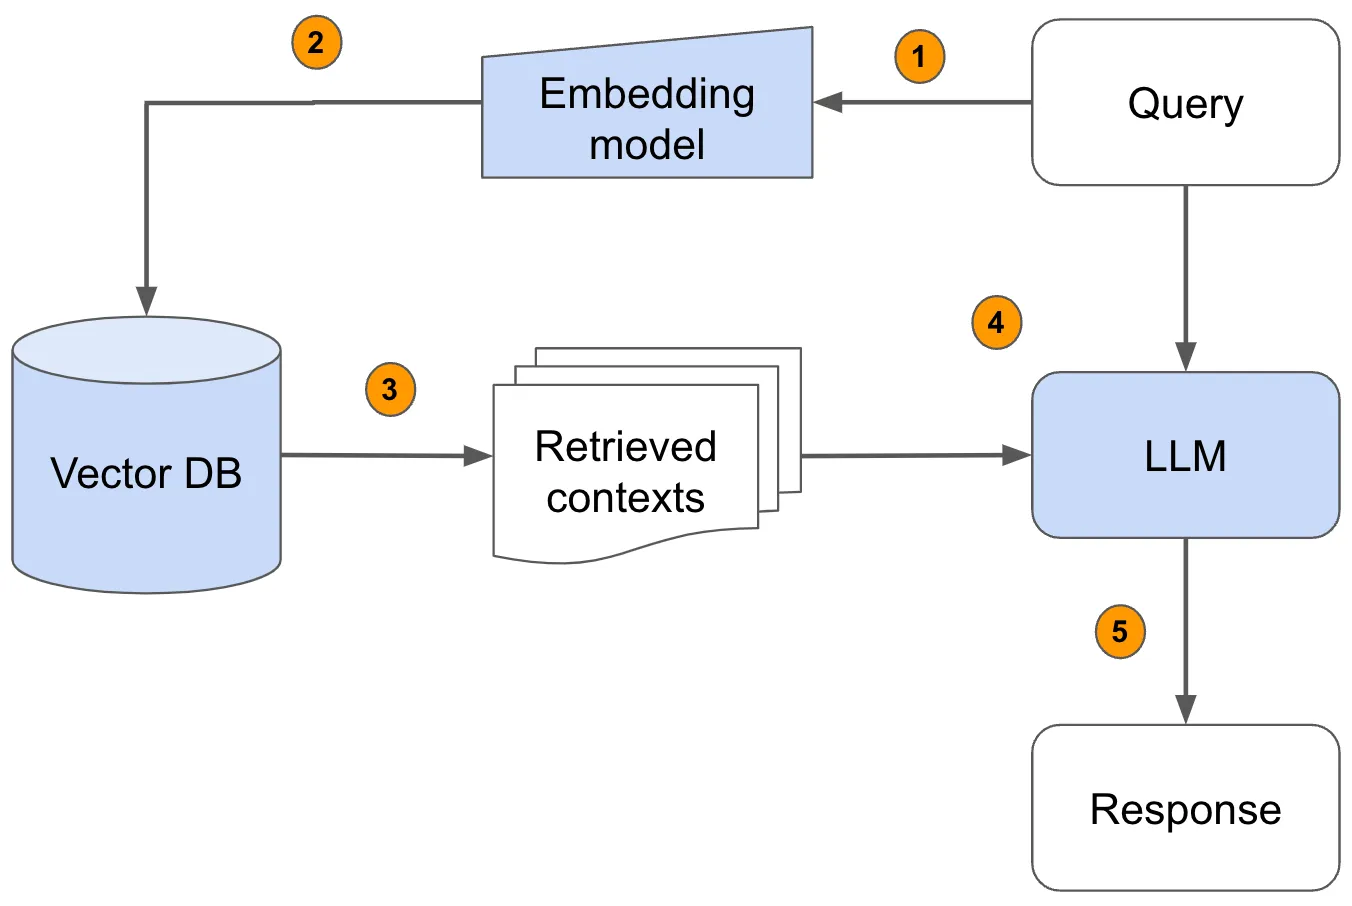


[Перевод на хабре](https://habr.com/ru/articles/841428/)

### Agent RAG

https://huggingface.co/learn/cookbook/agent_rag

## Примеры агентных систем, которые помогают на практике:

* Research: DeepResearch, AlphaXiv - paper to blog
* Code: Cursor and co
* Политическое/соц моделирование
* Ген. проектирование


---

# Домашка Agent Indexed RAG (WIP)

**Задача:**
Добавьте к уже готовому пайплайну RAG'а ваш собственный индекс, без векторной БД. На основе LLM'ки и иерархической структуры документации.

---

# Еще материалы:

### Test Time Scaling

* [🤗 huggingface/trl](https://github.com/huggingface/trl) HF transformers reinforcement learning
* [GRPO Qwen0.5 Huggingface Example](https://huggingface.co/docs/trl/main/grpo_trainer) - наглядный пример работы GRPO на маленькой модельке и игрушечной. задачке
* [The State of Reinforcement Learning for LLM Reasoning](https://magazine.sebastianraschka.com/p/the-state-of-llm-reasoning-model-training) (Sebastian Raschka, 2025) - свежий пост, но база
* [Mini-R1: Reproduce Deepseek R1 „aha moment“ a RL tutorial](https://www.philschmid.de/mini-deepseek-r1) - нужно 4 H100 и за 6 часов вы воспроизвели "aha moment" на настоящем, не игрушечном бенчмарке по математическим навыкам модельки
* [Speculations on Test-Time Scaling | Richard M. Karp Distinguished Lecture ](https://www.youtube.com/watch?v=6fJjojpwv1I) - Sasha Rush (Associate Professor @ Cornell University, Researcher @ HuggingFace 🤗) - сюда за интуицией)
* [Scaling test time compute with open models](https://huggingface.co/spaces/HuggingFaceH4/blogpost-scaling-test-time-compute) - Блог HF. Пример test time scaling, оочень интересный, но немножко тупиковый (см последнюю часть - "Where to go from here?"). [Разбор в Сиолошной](https://t.me/seeallochnaya/2136)
* [Почему базовые модели, поверх которых обучаются ризонеры хуже перформят на бенчах](https://t.me/seeallochnaya/2374) - (Сиолошная)
* [Почему ризонеры так сильно прокачивают модели](https://t.me/seeallochnaya/2379) - (Сиолошная)
* [DPO в GigaChat](https://habr.com/ru/companies/sberdevices/articles/890552/) - Как заводили DPO в GigaChat (спойлер, завелся, но не просто)
* [PPO и DPO в YandexGPT](https://habr.com/ru/companies/yandex/articles/817391/) - Как заводили PPO и DPO в YandexGPT

**Работает ли RL в LLM Alignment**
* [Reasoning models do not always say what they think](https://www.anthropic.com/research/reasoning-models-dont-say-think) - (anthropic, 2025) - [Статья](https://assets.anthropic.com/m/71876fabef0f0ed4/original/reasoning_models_paper.pdf), [Разбор в "Гречневые мысли"](https://t.me/buckwheat_thoughts/181 ). А что если, все, что генерят ризонеры во время процесса мышления - это просто побочный продукт? Может быть, на буст в качестве влияет большее количество сгенеренных токенов в контексте и интерпретация задачи на промежуточных слоях трансформера, но не то, что на самом деле генерируется при декодированиии?
* [Does Reinforcement Learning Really Incentivize Reasoning Capacity in LLMs Beyond the Base Model?](https://www.arxiv.org/abs/2504.13837) [Разбор AbstractDL](https://t.me/abstractDL/332)


### Agents

* [🤗 huggingface/smolagents](https://github.com/huggingface/smolagents)
* [OpenAI Agents SDK](https://openai.github.io/openai-agents-python/)
* [A practical guide to build agents](https://cdn.openai.com/business-guides-and-resources/a-practical-guide-to-building-agents.pdf)

